This is a tweaked run, where marginal damages in SIS in FUND are set to 0 for the first 54 timesteps. This is to test whether the marginal benefits in that region explain the very large and negative SCC we get for some parameter combinations.

In [1]:
using DataFrames
using Compat
using DataFramesMeta
using ProgressMeter

In [2]:
include("../fund.jl/src/fund.jl")
include("../fund.jl/src/marginaldamages.jl")

getmarginaldamages (generic function with 1 method)

Allocate some Dicts that hold the output per model. Key is model name

In [3]:
σ_squareds = @compat Dict{String,Matrix{Float64}}()
cpcs = @compat Dict{String,Matrix{Float64}}()
pops = @compat Dict{String,Matrix{Float64}}()
globpops = @compat Dict{String,Vector{Float64}}()
mds = @compat Dict{String,Matrix{Float64}}()

Dict{String,Array{Float64,2}} with 0 entries

# FUND

In [4]:
# Price inflator from $1995 to $2014, taken from http://www.bls.gov/data/inflation_calculator.htm
const priceInflatorFUND = 1.55

1.55

## Get $\sigma^2$ for FUND

In [5]:
x1 = readcsv("data/fund_sigmasquared.csv")
# Fix column/row layout
x2 = x1'
# Original uses a 5 year timestep, this repeats each year entry five times to get to a yearly matrix
x3 = repeat(x2, inner=[5,1])
# Create a matrix for later years that are not covered in the input file, by simply repeating the last year
x4 = repmat(x3[end,:], 195, 1)
# Combine the matrix for the covered years with the matrix for the later years
x5 = vcat(x3, x4)
# Done
σ_squareds["FUND"] = x5;

## Run FUND

In [6]:
param_fund = loadparameters("../fund.jl/data");
m_fund = getfund(params=param_fund);
run(m_fund)
pops["FUND"] = m_fund[:population, :populationin1][65:65+284,:];
globpops["FUND"] = vec(sum(m_fund[:population, :populationin1], 2))[65:65+284]
cpcs["FUND"] = (m_fund[:socioeconomic, :consumption] ./ m_fund[:population, :populationin1])[65:65+284,:] .* priceInflatorFUND
mds["FUND"] = getmarginaldamages(parameters=param_fund, emissionyear=2015)[65:65+284,:];

In [13]:
# ERROR
mds["FUND"][1:54,16] = 0.

0.0

# RICE

In [15]:
# Price inflator from $2005 to $2014, taken from http://www.bls.gov/data/inflation_calculator.htm
const priceInflatorRICE = 1.21

1.21

## Get $\sigma^2$ for RICE

In [16]:
x1 = readcsv("data/rice_sigmasquared.csv")
# Fix column/row layout
x2 = x1'
# Original uses a 5 year timestep, this repeats each year entry five times to get to a yearly matrix
x3 = repeat(x2, inner=[5,1])
# Create a matrix for later years that are not covered in the input file, by simply repeating the last year
x4 = repmat(x3[end,:], 195, 1)
# Combine the matrix for the covered years with the matrix for the later years
x5 = vcat(x3, x4)
# Done
σ_squareds["RICE"] = x5;

## Run RICE

In [17]:
x1 = readcsv("data/rice_md.csv")
# Fix column/row layout
x2 = x1'
# Original uses a 10 year timestep, this repeats each year entry ten times to get to a yearly matrix
x3 = repeat(x2, inner=[10,1])
# Leave out some later years to match σ_squared size
x4 = x3[1:285,:]
# Price level adjustment
x5 = x4 .* priceInflatorRICE
mds["RICE"] = x5;

In [18]:
x1 = readcsv("data/rice_cpc.csv")
# Fix column/row layout
x2 = x1'
# Original uses a 10 year timestep, this repeats each year entry ten times to get to a yearly matrix
x3 = repeat(x2, inner=[10,1])
# Leave out some later years to match σ_squared size
x4 = x3[1:285,:]
# Price level adjustment
x5 = x4 .* priceInflatorRICE
cpcs["RICE"] = x5;

In [19]:
x1 = readcsv("data/rice_population.csv")
# Fix column/row layout
x2 = x1'
# Original uses a 10 year timestep, this repeats each year entry ten times to get to a yearly matrix
x3 = repeat(x2, inner=[10,1])
# Leave out some later years to match σ_squared size
x4 = x3[1:285,:]
pops["RICE"] = x4
globpops["RICE"] = vec(sum(x4, 2));

# Compute SCC

Main equation of the paper

In [20]:
function equation11(cpc, pop, globpop, md, σsquared, σZero, γ, η, ρ, α, focus_region, I, c_ede)
    timesteps, regions = size(cpc)
    
    for t=1:timesteps, r=1:regions
        if σZero
            I[t, r] = 1.0 - exp(-0.5 * γ * 0.0)
        else
            I[t, r] = 1.0 - exp(-0.5 * γ * σsquared[t, r])
        end
    end
      
    for t=1:timesteps
        if γ == 1.
            # DOUBLE CHECK
            temp_x = 0.
            for r=1:regions
                temp_x += pop[t,r] * log(cpc[t,r] * (1.0 - I[t,r]))
            end
            c_ede[t] = exp( temp_x / globpop[t])
        else
            temp_x = 0.
            for r=1:regions
                temp_x += pop[t,r] * (cpc[t,r] * (1.0 - I[t,r]))^(1.0 - γ)
            end
            c_ede[t] =(temp_x/globpop[t])^(1.0 / (1.0 - γ))
        end
    end

    globc = 0.
    for r=1:regions
        globc += pop[1,r] * cpc[1,r]
    end
    
    cpc0x = focus_region == -1 ? globc / globpop[1] : cpc[1, focus_region]

    scc = 0.
    for t=1:timesteps, r=1:regions
        scc +=  md[t, r] *                      # P_rt * d_rt in the paper
                (1.0 + ρ)^(-(t-1)) *          # time discount factor
                (cpc0x / cpc[t, r])^γ *         # Normal equity weight
                (c_ede[t] / c_ede[1])^(γ - η) * # New thing
                (1.0 - I[t, r])^(-(γ + 1.0)) *  # New thing 2
                (1.0 - I[t, r])^(2 * α)         # This is Δ
    end
    return scc
end;

Modify this to run for different parameter combinations.

In [21]:
σZeros = [true, false]
γs = linspace(0., 2., 21)
ηs = linspace(0., 2., 21)
ρs = [0.001, 0.015, 0.03]
#ρs = linspace(0., 0.06, 13)
αs = [0., 1.];

Compute SCCs

In [22]:
df = DataFrame([Float64, Float64, Float64, Float64, Int64, Bool, Float64, String], [:rho, :eta, :gamma, :alpha, :focusregion, :sigmazero, :scc, :model], 0)

for model=["RICE", "FUND"]
    cpc = cpcs[model]
    pop = pops[model]
    globpop = globpops[model]
    md = mds[model]
    σSquared = σ_squareds[model]
    
    # Pre-allocate some arrays
    c_ede = similar(globpops[model])
    I = similar(mds[model]);    
    
    focus_regions = vcat(-1, [1:size(cpc,2)])
    
    progress = Progress(length(σZeros) * length(γs) * length(ηs) * length(ρs) * length(αs) * length(focus_regions),1,"Computing $model...")

    for σZero=σZeros, γ=γs, η=ηs, ρ=ρs, α=αs, focus_region=focus_regions
        scc = equation11(cpc, pop, globpop, md, σSquared, σZero, γ, η, ρ, α, focus_region, I, c_ede)
        push!(df, (ρ,η,γ,α,focus_region,σZero,scc,model))
        next!(progress)
    end
end

Computing RICE...100% Time: 0:01:23
Computing FUND...100% Time: 0:02:23


# Plotting

In [23]:
using PyPlot

Qt: Untested Windows version 10.0 detected!
INFO: Loading help data...


## Figure 1

In [24]:
df_temp = @where(df, (:rho .== 0.015) & (:focusregion .== 1) & (:alpha .== 1.) & (:gamma .<= 1.5) )

df_figure1_panelA_line1 = @where(df_temp, (:model .== "FUND") & (:sigmazero .== true) & (:eta .== :gamma) )
df_figure1_panelA_line2 = @where(df_temp, (:model .== "FUND") & (:sigmazero .== true) & (:eta .== 1.5) )

df_figure1_panelB_line1 = @where(df_temp, (:model .== "RICE") & (:sigmazero .== true) & (:eta .== :gamma) )
df_figure1_panelB_line2 = @where(df_temp, (:model .== "RICE") & (:sigmazero .== true) & (:eta .== 1.5) )

df_figure1_panelC_line1 = @where(df_temp, (:model .== "FUND") & (:sigmazero .== false) & (:eta .== :gamma) )
df_figure1_panelC_line2 = @where(df_temp, (:model .== "FUND") & (:sigmazero .== false) & (:eta .== 1.5) )

df_figure1_panelD_line1 = @where(df_temp, (:model .== "RICE") & (:sigmazero .== false) & (:eta .== :gamma) )
df_figure1_panelD_line2 = @where(df_temp, (:model .== "RICE") & (:sigmazero .== false) & (:eta .== 1.5) )

,rho,eta,gamma,alpha,focusregion,sigmazero,scc,model
1,0.015,1.5,0.0,1.0,1,false,57.651717048747884,RICE
2,0.015,1.5,0.1,1.0,1,false,63.772188617365295,RICE
3,0.015,1.5,0.2,1.0,1,false,71.22002432308315,RICE
4,0.015,1.5,0.3,1.0,1,false,80.35117353622098,RICE
5,0.015,1.5,0.4,1.0,1,false,91.63134408236762,RICE
6,0.015,1.5,0.5,1.0,1,false,105.67399633747337,RICE
7,0.015,1.5,0.6,1.0,1,false,123.29306930121491,RICE
8,0.015,1.5,0.7,1.0,1,false,145.57683013254675,RICE
9,0.015,1.5,0.8,1.0,1,false,173.9923290305846,RICE
10,0.015,1.5,0.9,1.0,1,false,210.53468324607348,RICE


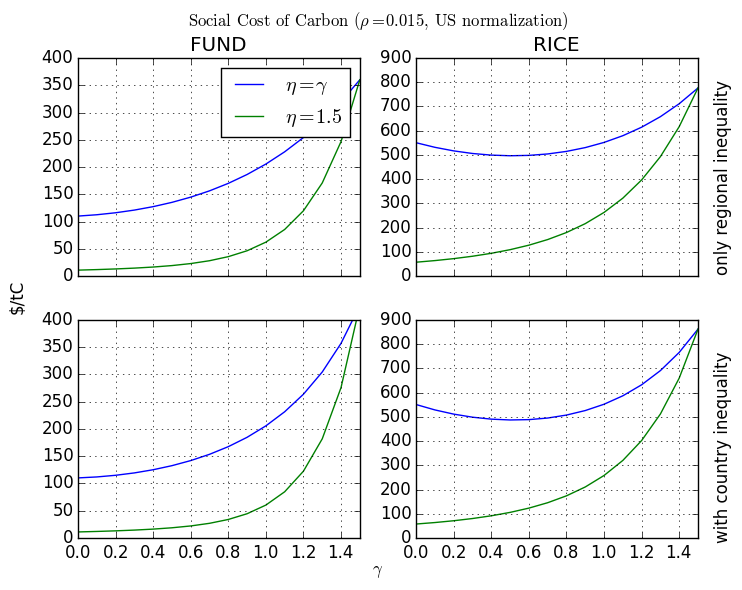

In [25]:
f, axs = subplots(2,2, sharex= true, sharey=false)

axs[1,1][:plot](df_figure1_panelA_line1[:gamma], df_figure1_panelA_line1[:scc])
axs[1,1][:plot](df_figure1_panelA_line2[:gamma], df_figure1_panelA_line2[:scc])
axs[1,1][:set_title]("FUND")
axs[1,1][:legend]([L"$\eta=\gamma$", L"$\eta=1.5$"])
axs[1,1][:set_xlim]([0., 1.5])
axs[1,1][:set_ylim]([0., 400])
axs[1,1][:grid]()

axs[1,2][:plot](df_figure1_panelB_line1[:gamma], df_figure1_panelB_line1[:scc])
axs[1,2][:plot](df_figure1_panelB_line2[:gamma], df_figure1_panelB_line2[:scc])
axs[1,2][:set_title]("RICE")
axs[1,2][:set_ylim]([0., 900])
axs[1,2][:grid]()

axs[2,1][:plot](df_figure1_panelC_line1[:gamma], df_figure1_panelC_line1[:scc])
axs[2,1][:plot](df_figure1_panelC_line2[:gamma], df_figure1_panelC_line2[:scc])
axs[2,1][:grid]()
axs[2,1][:set_ylim]([0., 400])

axs[2,2][:plot](df_figure1_panelD_line1[:gamma], df_figure1_panelD_line1[:scc])
axs[2,2][:plot](df_figure1_panelD_line2[:gamma], df_figure1_panelD_line2[:scc])
axs[2,2][:set_ylim]([0., 900])
axs[2,2][:grid]()

f[:text](0.92, 0.70, "only regional inequality", va="center", rotation="vertical")
f[:text](0.92, 0.25, "with country inequality", va="center", rotation="vertical")
f[:text](0.04, 0.5, "\$/tC", va="center", rotation="vertical")
f[:text](0.5, 0.04, L"$\gamma$", ha="center")
f[:suptitle](L"\mathrm{Social\/Cost\/of\/Carbon\/(}\rho=0.015,\/\mathrm{US\/normalization)}")

nothing

## Figure 2

In [26]:
using Gadfly
set_default_plot_size(20cm, 20cm)

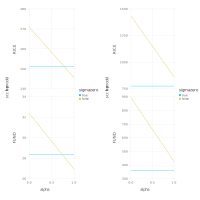

In [27]:
hstack(
plot(@where(df, (:rho .== 0.015) & (:focusregion .== 1) & (:alpha .<= 1000.) & (:gamma .== 0.7) & (:eta .== 1.5) ),
x="alpha", y="scc", ygroup="model", color="sigmazero", Geom.subplot_grid(free_y_axis=true, Geom.line)),
plot(@where(df, (:rho .== 0.015) & (:focusregion .== 1) & (:alpha .<= 1000.) & (:gamma .== 1.5) & (:eta .== 1.5) ),
x="alpha", y="scc", ygroup="model", color="sigmazero", Geom.subplot_grid(free_y_axis=true, Geom.line)),
)